In [79]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

# !pip freeze > requirements.txt

In [80]:
data = pd.read_csv('https://lms.skillfactory.ru/assets/courseware/v1/12aeb6a8af2d5cdf500e55d3ccbb9f8e/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/insurance.zip')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Набор данных содержит следующие столбцы:
* age — возраст основного бенефициара;
* sex — пол страхового подрядчика;
* bmi — индекс массы тела ($кг/м^2$), в идеале — от 18.5 до 24.9;
* children — количество детей, охваченных медицинской страховкой;
* smoker — является ли человек курящим;
* region — жилой район США (северо-восток, юго-восток, северо-запад, юго-запад);
* charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

In [81]:
data.shape

(1338, 7)

Выведем информацию о пропусках и о типах данных

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Строим гистограммы и коробчатые диаграммы числовых признаков

In [83]:
types = data.dtypes
num_features = list(types[types != 'object'].index)
num_features

['age', 'bmi', 'children', 'charges']

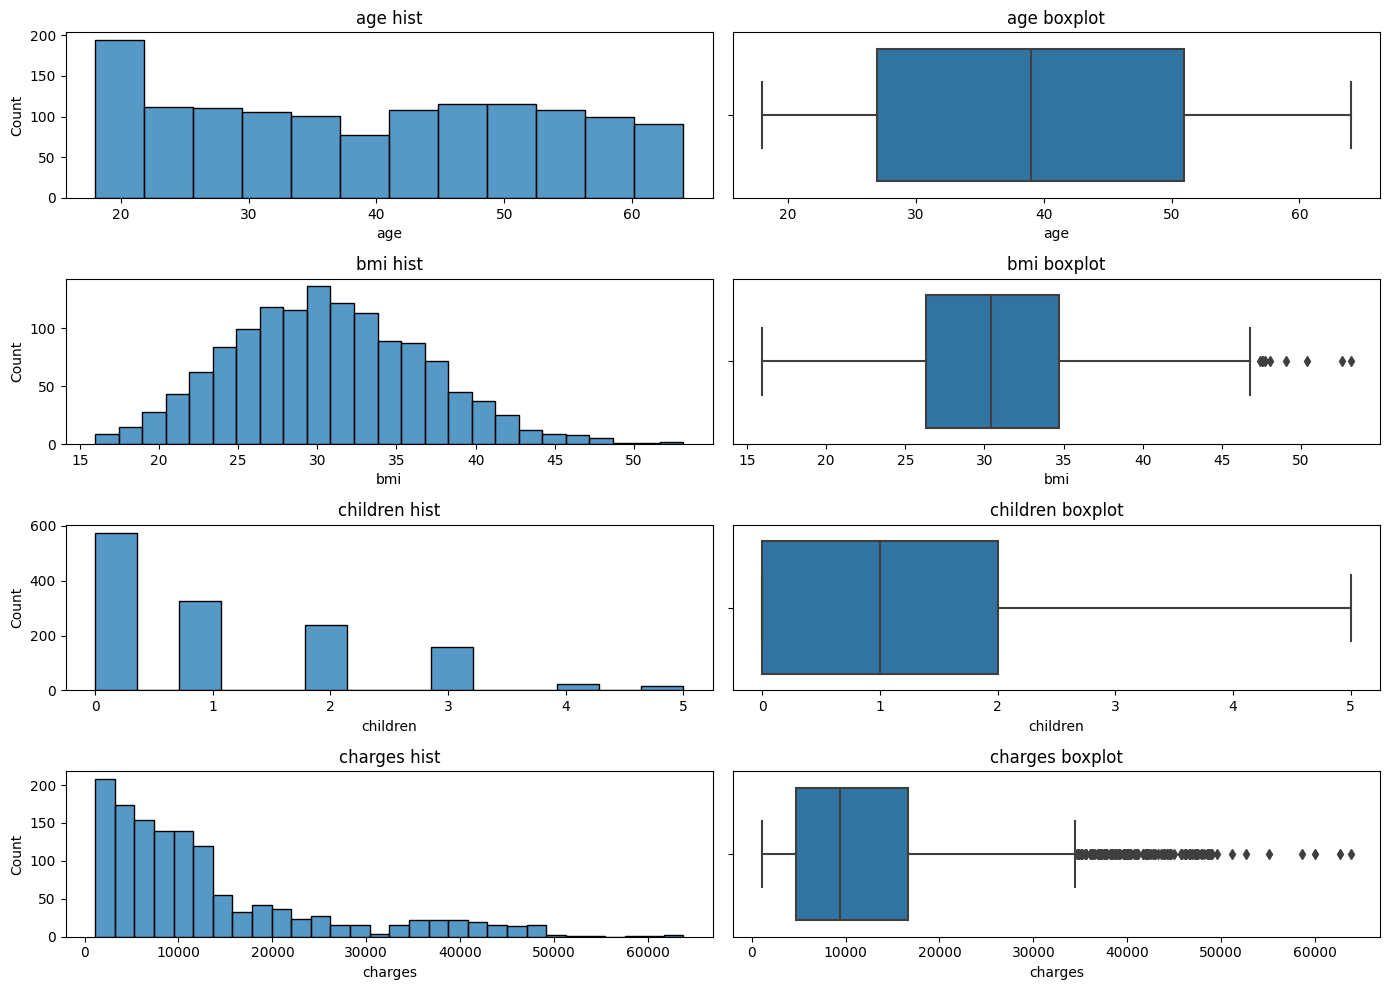

In [84]:
n = len(num_features) # определяем количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(14, 10))
# цикл для всех признаков из списка
for i, feature in enumerate(num_features):
    # строим гистограмму распределения признака
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    histplot.set_title(f'{feature} hist')
    # строим коробчатую диаграмму распределения признака
    boxplot = sns.boxplot(data=data, x=feature, ax=axes[i][1])
    boxplot.set_title(f'{feature} boxplot')
plt.tight_layout() # выравнивание графиков

Строим столбчатые диаграммы медианных медицинских расходов в зависимости от категориальных признаков

In [85]:
# список категориальных признаков
cat_features = list(types[types == 'object'].index)
cat_features

['sex', 'smoker', 'region']

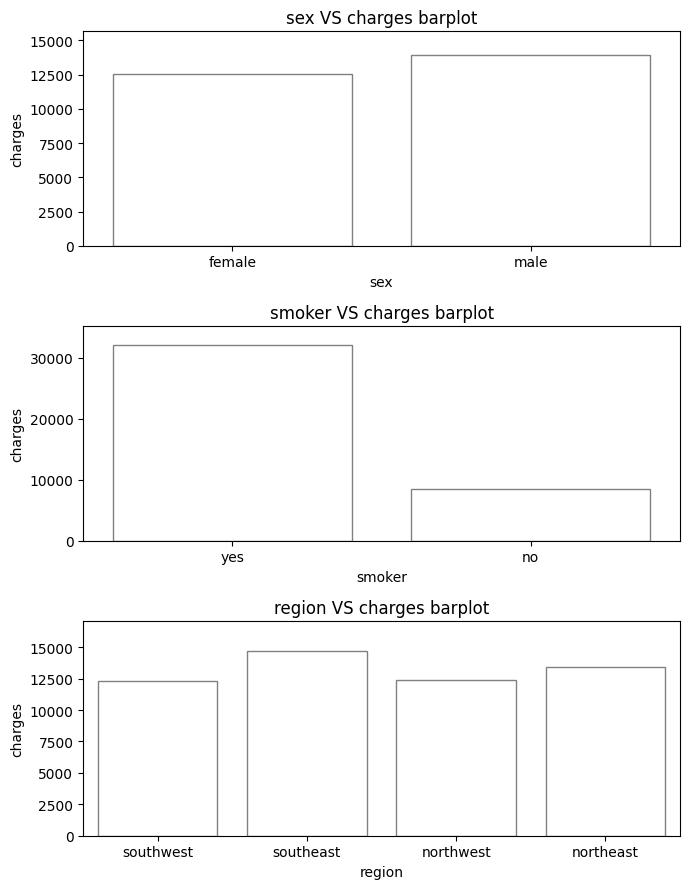

In [86]:
n = len(cat_features) # определяем количество числовых признаков
fig, axes = plt.subplots(n, figsize=(7, 9))
# цикл для всех признаков из списка
for i, feature in enumerate(cat_features):
    # строим столбчатую диаграмму мед расходов в зависимости от признаков
    barplot = sns.barplot(data=data, x=feature, y=data['charges'], 
                          ax=axes[i], edgecolor=".5", facecolor=(0, 0, 0, 0),
                          errwidth=0)
    barplot.set_title(f'{feature} VS charges barplot')
plt.tight_layout() # выравнивание графиков

Строим диаграммы рассеяния зависимости целевого признака от других числовых в разрезе категориальных

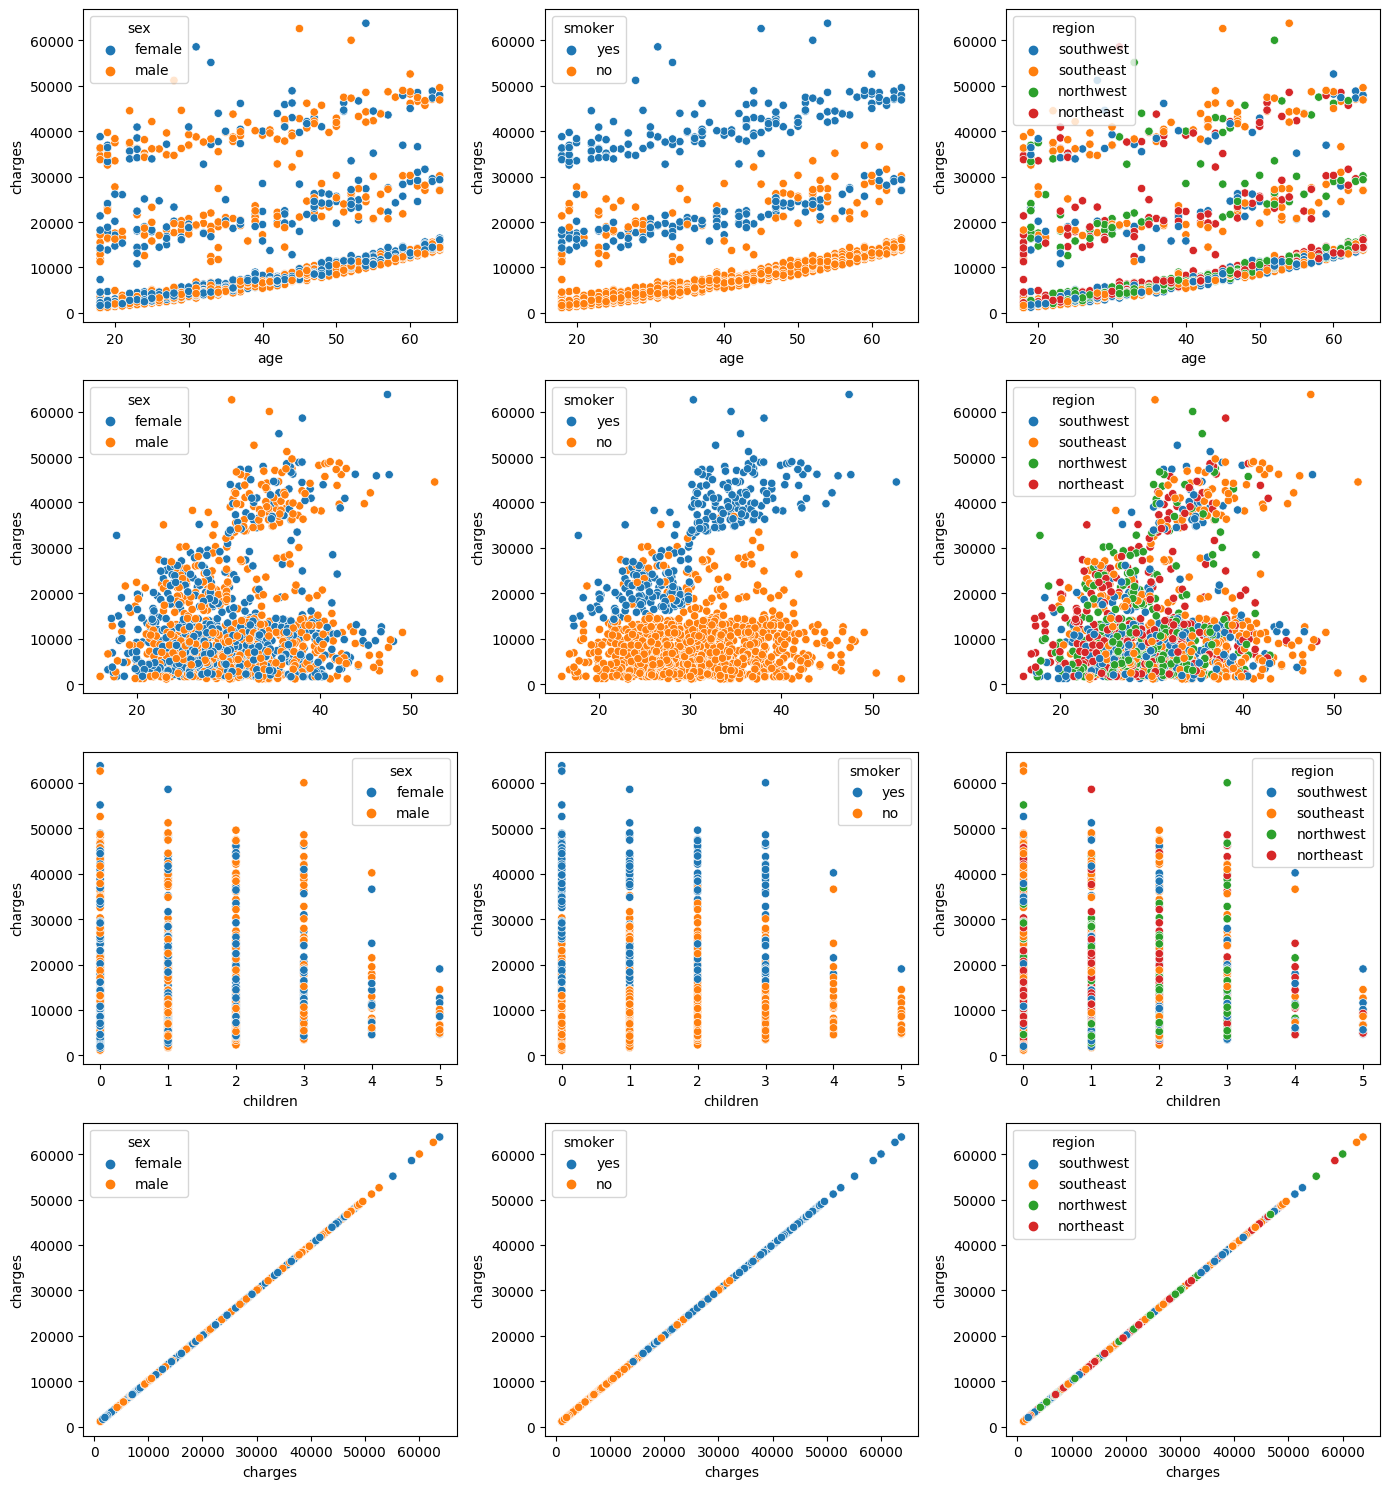

In [87]:
num_len = len(num_features) # определяем количество числовых признаков
cat_len = len(cat_features) # определяем количество категориальных признаков
fig, axes = plt.subplots(num_len, cat_len, figsize=(14, 15))
# цикл для всех числовых признаков (новая строка)
for i, num_feature in enumerate(num_features):
    for j, cat_feature in enumerate(cat_features):
        # строим диаграмму
        scatter = sns.scatterplot(data=data, x=num_feature, y=data['charges'], 
                                ax=axes[i][j], hue=cat_feature)
        histplot.set_title(f'Scatter от {num_feature} от {cat_feature}')
plt.tight_layout() # выравнивание графиков

**Кодируем категориальные признаки**

In [88]:
data['smoker'] = data['smoker'].apply(lambda x: 1 if x == 'yes' else 0)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)

# оставшиеся категориальные признаки кодируемс с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


Выделяем факторы и целевой признак в отдельные таблицы

In [89]:
features = data.drop(columns='charges').columns
X, y = data[features], data['charges']

**Начинаем работу над моделью**

Разделяем набор данных на тренировочную и тестовую

In [90]:
# разделяем датасет на тренировочную и тестовую выборки. Метод train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, # таблица с наблюдениями и вектор правильных овтетов
    test_size=0.2,
    random_state=42
)

# выводим размеры полученых выборок
print(f'Train shape: - X:{X_train.shape}: y - {y_train.shape}')
print(f'Test shape: - X:{X_test.shape}: y - {y_test.shape}')

Train shape: - X:(1070, 9): y - (1070,)
Test shape: - X:(268, 9): y - (268,)


Обучаем модель линейной регрессии аналитическим методом

In [91]:
# создаем объект класса
lr_analyt = linear_model.LinearRegression()
# обучаем модель на тренировочных данных
lr_analyt.fit(X_train, y_train)
# находим чему равын параметры
print('w0: {}'.format(lr_analyt.intercept_)) #свободный член w0
print('w1: {}'.format(lr_analyt.coef_))      #остальные параметры модели w1, w2, ..., wm

w0: -12390.804294570278
w1: [ 2.56975706e+02 -1.85916916e+01  3.37092552e+02  4.25278784e+02
  2.36511289e+04  4.59585244e+02  8.89079180e+01 -1.98279052e+02
 -3.50214110e+02]


С помощью модели делаем предсказание на тренировочной выборке

Создаем функцию вывода расчитанных метрик

In [102]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    """Выводит информацию о метриках

    Args:
        y_train (_type_): Series
        y_train_predict (_type_): Series
        y_test (_type_): Series
        y_test_predict (_type_): Series
    """
    print(f'Train R^2: {round(metrics.r2_score(y_train, y_train_predict), 4)}')
    print(f'Train MAE: {round(metrics.mean_absolute_error(y_train, y_train_predict), 3)}')
    print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train, y_train_predict), 3)}')
    print()
    
    print(f'Test R^2: {round(metrics.r2_score(y_test, y_test_predict), 4)}')
    print(f'Test MAE: {round(metrics.mean_absolute_error(y_test, y_test_predict), 3)}')
    print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_test_predict), 3)}')

In [93]:
y_train_predict = lr_analyt.predict(X_train)
y_test_predict = lr_analyt.predict(X_test)

# выводим метрики
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 0.422

Test R^2: 0.784
Test MAE: 4181.194
Test MAPE: 0.469


Строим диаграмму boxplot для визуализации ошибок модели линейной регрессии на тренировочной и тестовой выборках.

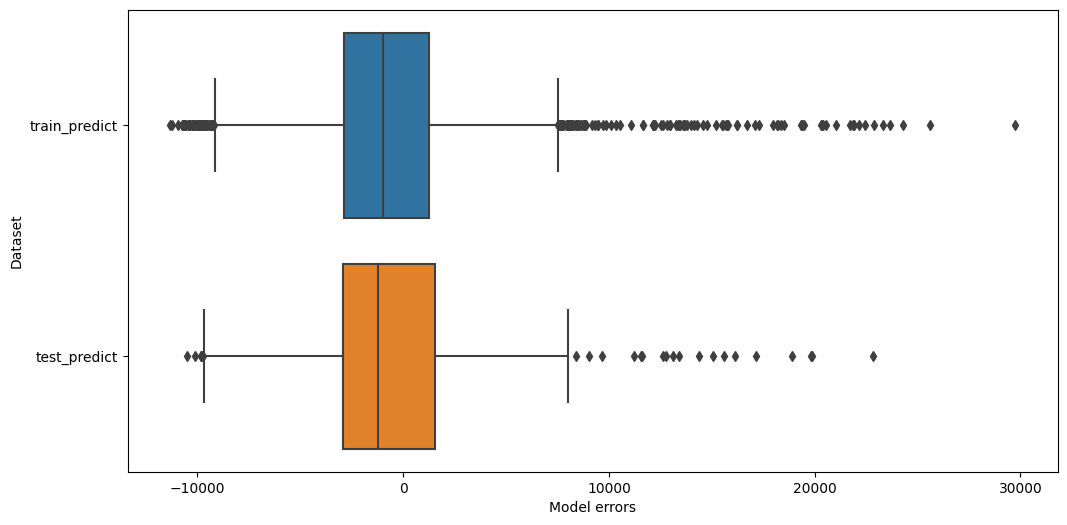

In [94]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6))     # фигура + координатная плоскость
#Ошибки модели на одном факторе LSTAT
y_errors_train = y_train - y_train_predict
y_errors_test = y_test - y_test_predict

#Для удобства визуализации составим DataFrame из ошибок
errors_df = pd.DataFrame(
    {'train_predict': y_errors_train, 
     'test_predict': y_errors_test
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=errors_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Dataset'); #название оси ординат

**Проведем нормализацию**

In [95]:
# создаем объект класса
scaller = preprocessing.MinMaxScaler()
# вычисляем параметры нормализации
scaller.fit(X_train)
# производим преобразования
X_train_scaled = scaller.transform(X_train)
X_test_scaled = scaller.transform(X_test)

**Создаем полиномиальные признаки**

In [96]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
# вычисляем параметры
poly.fit(X_train_scaled)
# производим преобразования для каждой выборки
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 54)
Test shape: (268, 54)


**Обучаем модель на полиномиальных признаках**

In [103]:
# создаем экземпляр класса
lr_analyt_poly = linear_model.LinearRegression()
# обучаем модель
lr_analyt_poly.fit(X_train_scaled_poly, y_train)
# предсказываем значения
y_train_predict_poly = lr_analyt_poly.predict(X_train_scaled_poly)
y_test_predict_poly = lr_analyt_poly.predict(X_test_scaled_poly)

# выводим метрики
print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.8418
Train MAE: 2906.12
Train MAPE: 0.296

Test R^2: 0.8665
Test MAE: 2741.678
Test MAPE: 0.304


Выводим значения коэффициентов полученой модели

In [104]:
print('w0: {}'.format(lr_analyt_poly.intercept_)) #свободный член w0
print('w1: {}'.format(lr_analyt_poly.coef_))      #остальные параметры модели w1, w2, ..., wm

w0: 4662166100954783.0
w1: [-3.51760358e+16  1.61021746e+15  2.47615914e+15 -4.81004112e+15
  1.29275952e+14 -3.52012791e+15 -2.48431178e+15 -2.59881721e+15
 -1.45044066e+15  8.44800000e+03  8.02000000e+02  9.72000000e+02
 -1.67600000e+03  1.70000000e+02  3.51760358e+16  3.51760358e+16
  3.51760358e+16  3.51760358e+16 -9.23535566e+14  6.51750000e+02
 -1.23750000e+03  2.63000000e+02 -6.86681899e+14 -6.86681899e+14
 -6.86681899e+14 -6.86681899e+14 -9.69775000e+03  1.55693750e+03
  5.48399844e+04 -2.47615914e+15 -2.47615914e+15 -2.47615914e+15
 -2.47615914e+15 -2.09825000e+03 -2.23150000e+03  4.81004112e+15
  4.81004112e+15  4.81004112e+15  4.81004112e+15  2.54047741e+13
 -1.54680726e+14 -1.54680726e+14 -1.54680726e+14 -1.54680726e+14
 -1.14203819e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.17785432e+15  0.00000000e+00  0.00000000e+00 -2.06334889e+15
  0.00000000e+00 -3.21172544e+15]


Значения коэффициентов очень высокие, модель неустойчива, необходима регуляризация.

**Строим модель с L1-регуляризацией (Lasso)**

In [106]:
# инициализируем объект класса
lr_lasso = linear_model.Lasso(max_iter=2000)
# обучаем модель
lr_lasso.fit(X_train_scaled_poly, y_train)
# предсказываем
y_train_predict_poly_lasso = lr_lasso.predict(X_train_scaled_poly)
y_test_predict_poly_lasso = lr_lasso.predict(X_test_scaled_poly)

# выводим метрики
print_metrics(y_train, y_train_predict_poly_lasso, y_test, y_test_predict_poly_lasso)

Train R^2: 0.8418
Train MAE: 2890.473
Train MAPE: 0.294

Test R^2: 0.8668
Test MAE: 2719.334
Test MAPE: 0.301


Выводим значения коэффициентов полученой модели

In [112]:
print('w0: {}'.format(lr_analyt_poly.intercept_)) #свободный член w0
print(f'w1: {np.round(lr_analyt_poly.coef_, 2)}')      #остальные параметры модели w1, w2, ..., wm

w0: 4662166100954783.0
w1: [-3.51760358e+16  1.61021746e+15  2.47615914e+15 -4.81004112e+15
  1.29275952e+14 -3.52012791e+15 -2.48431178e+15 -2.59881721e+15
 -1.45044066e+15  8.44800000e+03  8.02000000e+02  9.72000000e+02
 -1.67600000e+03  1.70000000e+02  3.51760358e+16  3.51760358e+16
  3.51760358e+16  3.51760358e+16 -9.23535566e+14  6.51750000e+02
 -1.23750000e+03  2.63000000e+02 -6.86681899e+14 -6.86681899e+14
 -6.86681899e+14 -6.86681899e+14 -9.69775000e+03  1.55694000e+03
  5.48399800e+04 -2.47615914e+15 -2.47615914e+15 -2.47615914e+15
 -2.47615914e+15 -2.09825000e+03 -2.23150000e+03  4.81004112e+15
  4.81004112e+15  4.81004112e+15  4.81004112e+15  2.54047741e+13
 -1.54680726e+14 -1.54680726e+14 -1.54680726e+14 -1.54680726e+14
 -1.14203819e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.17785432e+15  0.00000000e+00  0.00000000e+00 -2.06334889e+15
  0.00000000e+00 -3.21172544e+15]


Значения коэффициентов по прежнему высокие. Незнначительное количество коэффициентов обнулилось, т.к. модель посчитала, что они не важны в расчете

**Строим модель с L2-регуляризацией (Lasso)**

In [114]:
# инициализируем объект класса
lr_ridge = linear_model.Ridge(max_iter=2000)
# обучаем модель
lr_ridge.fit(X_train_scaled_poly, y_train)
# предсказываем
y_train_predict_poly_ridge = lr_ridge.predict(X_train_scaled_poly)
y_test_predict_poly_ridge = lr_ridge.predict(X_test_scaled_poly)

# выводим метрики
print_metrics(y_train, y_train_predict_poly_ridge, y_test, y_test_predict_poly_ridge)

Train R^2: 0.8386
Train MAE: 2948.804
Train MAPE: 0.295

Test R^2: 0.8633
Test MAE: 2860.555
Test MAPE: 0.314


**Строим модель с L2-регуляризацией (Lasso) с учетом логарифмирования целевого признака**

In [115]:
# инициализируем объект класса
lr_ridge = linear_model.Ridge(max_iter=2000)
# обучаем модель
lr_ridge.fit(X_train_scaled_poly, np.log(y_train))
# предсказываем
y_train_predict_poly_ridge = np.exp(lr_ridge.predict(X_train_scaled_poly))
y_test_predict_poly_ridge = np.exp(lr_ridge.predict(X_test_scaled_poly))

# выводим метрики
print_metrics(y_train, y_train_predict_poly_ridge, y_test, y_test_predict_poly_ridge)

Train R^2: 0.8158
Train MAE: 2684.509
Train MAPE: 0.182

Test R^2: 0.8569
Test MAE: 2424.021
Test MAPE: 0.179
